# Results
All graphs and results. For discussion please read associated paper.

In [15]:
# Imports for the rest of the notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from discrete_skip_gram.util import stats_string
from tabulate import tabulate
def load_output(path):
    return np.load('../experiments/output/{}'.format(path))
eps = 1e-9

## Cooccurrence matrix

Import precalculated cooccurrence matrix generated from Brown corpus.

Calculate marginal and conditional entropy.

In [34]:
# Load and normalize cooccurrence matrix
coo = load_output('cooccurrence.npy').astype(np.float32)
p = coo / np.sum(coo, axis=None)
print('Shape of cooccurrence matrix is {}'.format(p.shape))

Shape of cooccurrence matrix is (4946L, 4946L)


In [4]:
# Calculate marginal entropy (unigram)
marginal = np.sum(p, axis=1, keepdims=True)
marginal_nll = np.sum(marginal * -np.log(marginal+eps), axis=None) # E(x) = p(x)*log(p(x))
print('Marginal entropy is {}'.format(marginal_nll))

Marginal entropy is 5.91309642792


In [5]:
# Calculate conditional entropy (skipgram)
conditional = p / marginal
conditional_nll = np.sum(p * -np.log(conditional+eps), axis=None) # H(y|x) = p(x,y)*log(p(y|x))
print('Conditional entropy is {}'.format(conditional_nll))

Conditional entropy is 5.32560062408


## Random Baseline
Randomly cluster the vocabulary and calculate the conditional entropy of the clusters. Conditional entropy decreases as the number of clusters increases.

Cluster the vocabulary into a random binary tree and calculate the conditional entropy of each level of the tree. Conditional entropy decreases as the depth of the tree increases.

Iterations: 100


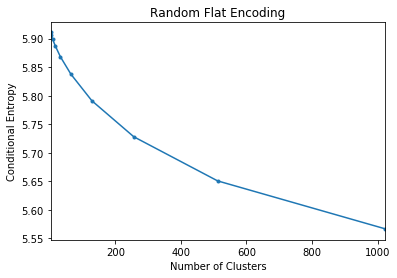

Number of Clusters,Mean Conditional Entropy,Std
2,5.91089,0.000353488
4,5.90664,0.000643125
8,5.89946,0.000901418
16,5.88777,0.00140333
32,5.86821,0.00143286
64,5.83775,0.00177347
128,5.79114,0.00181084
256,5.72796,0.00172552
512,5.65055,0.00197066
1024,5.56641,0.00180625


In [30]:
# Random flat encodings with different numbers of clusters
random = load_output('skipgram_flat_random.npz')
print('Iterations: {}'.format(random['nlls'].shape[1]))
# Plot entropy by number of clusters
mean = np.mean(random['nlls'], axis=1)
std = np.std(random['nlls'], axis=1)
plt.errorbar(random['z_ks'], mean, yerr=std, markersize=3, fmt='-o')
plt.title('Random Flat Encoding')
plt.ylabel('Conditional Entropy')
plt.xlabel('Number of Clusters')
plt.xlim(2, 1024)
plt.show()
# Tabulate entropy by number of clusters
t = np.stack([random['z_ks'], mean, std], axis=1)
HTML(tabulate(t, tablefmt='html', headers=['Number of Clusters', 'Mean Conditional Entropy', 'Std']))

Iterations: 50


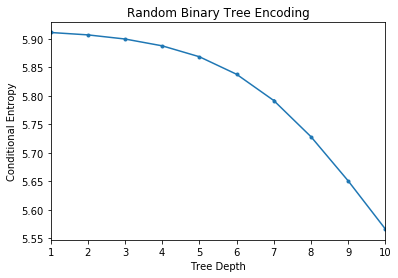

Tree Depth,Mean Conditional Entropy,Std
1,5.91088,0.000436061
2,5.90671,0.000568841
3,5.89945,0.000856081
4,5.8875,0.00120805
5,5.86835,0.00146809
6,5.83765,0.00168684
7,5.7916,0.00197922
8,5.72817,0.00191247
9,5.65073,0.00187701
10,5.56624,0.00149767


In [31]:
# Random tree encoding
tree_random = load_output('skipgram_tree_random.npz')
print('Iterations: {}'.format(tree_random['nlls'].shape[0]))
# Plot entropy by depth
mean = np.mean(tree_random['nlls'], axis=0)
std = np.std(tree_random['nlls'], axis=0)
plt.errorbar(np.arange(1,11), mean, yerr=std, markersize=3, fmt='-o')
plt.title('Random Binary Tree Encoding')
plt.ylabel('Conditional Entropy')
plt.xlabel('Tree Depth')
plt.xlim(1,10)
plt.show()
# Tabulate entropy by depth
t = np.stack([np.arange(1,11), mean, std], axis=1)
HTML(tabulate(t, tablefmt='html', headers=['Tree Depth','Mean Conditional Entropy', 'Std']))

## Baseline Skipgram Models

Train baseline skipgram models with different numbers of hidden units (`p=softmax(xW+b)`, `loss=expected(-log(p))`).

Performance with few units approaches the analytically calculated marginal entropy.

Performance with many units approaches the calculated conditional entropy.

## Binary Models

Experiments with models that cluster the vocabulary into two groups and attempt to minimize the conditional entropy of those clusters.

## Flat Models (k=1024)
Experiments with models that cluster the vocabulary into 1024 groups (`2**10`) and attempt to minimize the conditional entropy of the clusters.

Skipgram model

Random assignment

## Flat models

In [32]:
flat = load_output('skipgram_flat.npz')
print("Flat NLL: {}".format(stats_string(flat['nlls'])))
print("Flat Utilization: {}".format(stats_string(flat['utilizations'])))

Flat NLL: Mean 5.5480435445, Std 0.000778813805342, Min 5.54713744241, Max 5.54945816655, N 5
Flat Utilization: Mean 809.4, Std 4.8, Min 804, Max 816, N 5


Flat model with regularization

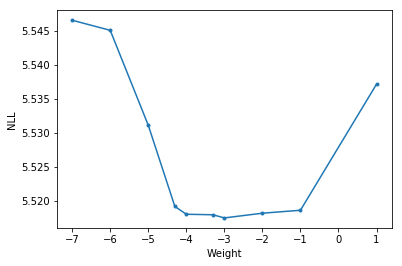

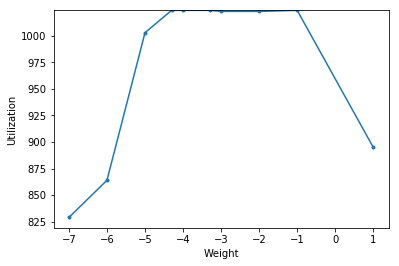

In [35]:
# Flat model with balance regularizer
flat_b = load_output('skipgram_flat-b.npz')
# plot NLL by regularization weight
mean = np.mean(flat_b['nlls'], axis=1)
x = np.log10(flat_b['weights'])
plt.plot(x, mean, markersize=3, marker='o')
plt.ylabel('NLL')
plt.xlabel('Weight')
plt.show()
meanu = np.mean(flat_b['utilizations'], axis=1)
plt.plot(x, meanu, markersize=3, marker='o')
plt.ylabel('Utilization')
plt.xlabel('Weight')
plt.ylim(None, 1024)
plt.show()